In [4]:
import sys
sys.path.append('/cluster/sj1')
sys.path.append('/cluster/sj1/bb_opt/src')

In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from collections import namedtuple
import torch.distributions as tdist
import bb_opt.src.reparam_trainer as reparam
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
from gpu_utils.utils import gpu_init
from tqdm import tnrange
import pandas as pd
from bb_opt.src.utils import train_val_test_split
from sklearn.model_selection import train_test_split

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on GPU 0


In [1]:
import utils

ModuleNotFoundError: No module named 'utils'

In [6]:
Params = namedtuple('params', [
    'lr', 
    'num_latents', 
    'output_dist_std', 
    'output_dist_fn', 
    'prior_mean', 
    'prior_std', 
    'num_epochs', 
    'num_samples', 
    'batch_size', 
    'device', 
    'exp_noise_samples'])
params = Params(
    batch_size=100, 
    num_latents=20,
    output_dist_std=0.01,
    output_dist_fn=tdist.Normal, 
    num_samples=10, 
    exp_noise_samples=2, 
    lr=1e-3, 
    prior_mean=0., 
    prior_std=1., 
    device='cuda', 
    num_epochs=1000)

In [7]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    #ax = sns.regplot(predicted, true)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [10]:
n_train = 1000

project = "dna_binding"
dataset = "crx_ref_r1"

root = "/cluster/sj1/bb_opt/"
data_dir = root+"data/"+project+"/"+dataset+"/"
inputs = np.load(data_dir+"inputs.npy")
labels = np.load(data_dir+"labels.npy")


exclude_top = 0.01

idx = np.arange(labels.shape[0])

sort_idx = labels.argsort()[:-int(labels.shape[0]*exclude_top)]
idx = idx[sort_idx]

train_idx, _, _ = train_val_test_split(idx, split=[n_train, 0])
train_idx2, _, test_idx2 = train_val_test_split(n_train, split=[0.9, 0])

test_idx = train_idx[test_idx2]
train_idx = train_idx[train_idx2]

train_inputs = inputs[train_idx]
train_labels = labels[train_idx]

val_inputs = inputs[test_idx]
val_labels = labels[test_idx]


#train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
#train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

In [11]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std

In [397]:
N_HIDDEN = 100
NON_LINEARITY = "ReLU"

class Qz(nn.Module):
    def __init__(self, num_latent, prior_std=1):
        super(Qz, self).__init__()
        self.mu_z = Parameter(torch.zeros(num_latent))
        self.std_z = Parameter(torch.ones(num_latent)*prior_std)
        
    def forward(self, e):
        return self.mu_z.unsqueeze(0) + e*self.std_z.unsqueeze(0)
    
class DnaNN(nn.Module):
    def __init__(self, n_inputs, num_latent, num_hidden, activation):
        super(DnaNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs + num_latent, num_hidden),
            #nn.Linear(n_inputs, num_hidden),
            getattr(nn, activation)(),
            nn.Linear(num_hidden, 2),
        )
        
    def forward(self, x, z, resize_at_end=False):
        assert x.ndimension() == 2
        num_samples = z.shape[0]
        N = x.shape[0]
        
        x = utils.collated_expand(x, num_samples)
        z = z.repeat([N, 1])
        x = torch.cat([x, z], dim=1)
        
        x = self.net(x)
        
        if resize_at_end:
            x = x.view([N, num_samples]).transpose()
        return x
        
        
def get_model_nn(n_inputs: int = 512, num_latent: int = 20, prior_std=1):
    global device
    device = device or "cpu"

    model = DnaNN(n_inputs, num_latent, N_HIDDEN, NON_LINEARITY).to(device)

    def init_weights(module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(
                module.weight.data, mode="fan_out", nonlinearity="relu"
            )

    model.apply(init_weights)
    model.train()
    
    qz = Qz(num_latent, prior_std).to('cuda')
    qz.train()
    
    mu_e = torch.zeros(num_latent, requires_grad=False).to(device)
    std_e = torch.ones(num_latent, requires_grad=False).to(device)
    
    e_dist = tdist.Normal(mu_e + params.prior_mean, std_e*params.prior_std)
    
    return model, qz, e_dist

In [26]:
import bb_opt.src.reparam_trainer as reparam

In [385]:
params = Params(
    batch_size=10,
    num_epochs=500,
    num_latents=15, 
    output_dist_fn=tdist.Normal, 
    num_samples=20, 
    exp_noise_samples=3, 
    lr=1e-4, 
    prior_mean=0., 
    prior_std=3.,
    device='cuda', 
    output_dist_std=1.
)

In [398]:
model, qz, e_dist = get_model_nn(inputs.shape[1], params.num_latents, params.prior_std)

train_losses = []
train_kl_losses = []
train_hsic_losses = []
val_losses = []

train_corrs = []
val_corrs = []

N = train_inputs.shape[0]
num_batches = N//params.batch_size
print('num_batches:', num_batches)

model_parameters = []
for m in [model, qz]:
    model_parameters += list(m.parameters())
batches, optim = reparam.init_train(params, model_parameters, train_inputs, train_labels)

num_batches: 90


In [403]:
import bb_opt.src.reparam_trainer as reparam

In [404]:
model_path = "crx_100_starter_sid"

progress = tnrange(params.num_epochs)

train_X = torch.FloatTensor(train_inputs)
train_Y = torch.FloatTensor(train_labels)
val_X = torch.FloatTensor(val_inputs)
val_Y = torch.FloatTensor(val_labels)


for epoch_iter in progress:
    for bi in range(num_batches):
        bs = batches[bi]
        be = batches[bi+1]
        bN = be-bs

        bX = train_X[bs:be]
        bY = train_Y[bs:be]

        for k in range(1):
            e = reparam.generate_prior_samples(params.num_samples, e_dist)
            loss, log_prob_loss, kl_loss, hsic_loss, _, _ = reparam.compute_loss(params, bX, bY, model, qz, e, hsic_lambda=20.)
            train_losses += [log_prob_loss]
            train_kl_losses += [kl_loss]
            train_hsic_losses += [hsic_loss]

            optim.zero_grad()
            loss.backward()
            optim.step()
    
    e = reparam.generate_prior_samples(params.num_samples, e_dist)    
    preds = reparam.predict(train_X, model, qz, e)[:, :, 0].mean(1)
    assert preds.shape == train_labels.shape, str(preds.shape) + " == " + str(train_labels.shape)
        
    train_corrs.append(kendalltau(preds, train_labels)[0])

    preds = reparam.predict(val_X, model, qz, e)[:, :, 0].mean(1)
    assert preds.shape == val_labels.shape
    
    val_corr = kendalltau(preds, val_labels)[0]

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")
    progress.set_postfix({'hsic_loss' : train_hsic_losses[-1], 'kl_loss' : train_kl_losses[-1], 'log_prob_loss' : train_losses[-1]})

A Jupyter Widget

KeyboardInterrupt: 

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


train_corrcoef: 0.7764331577107286
val_corrcoef: 0.7000901026064995


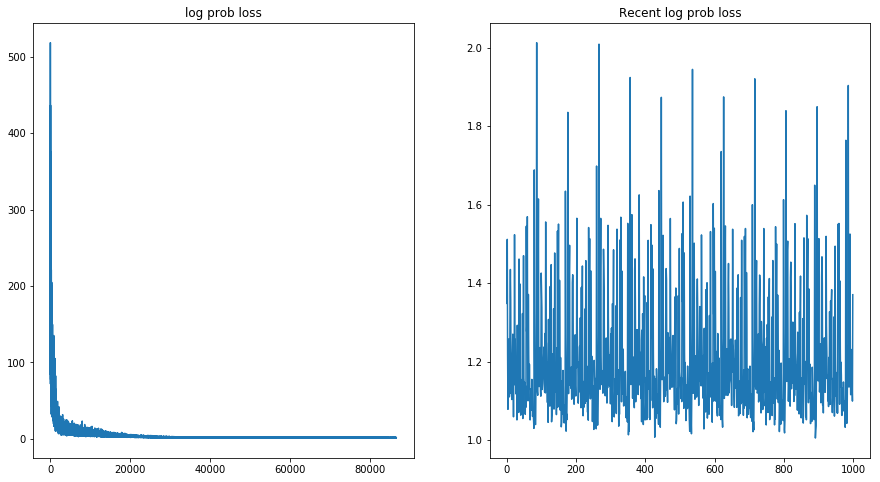

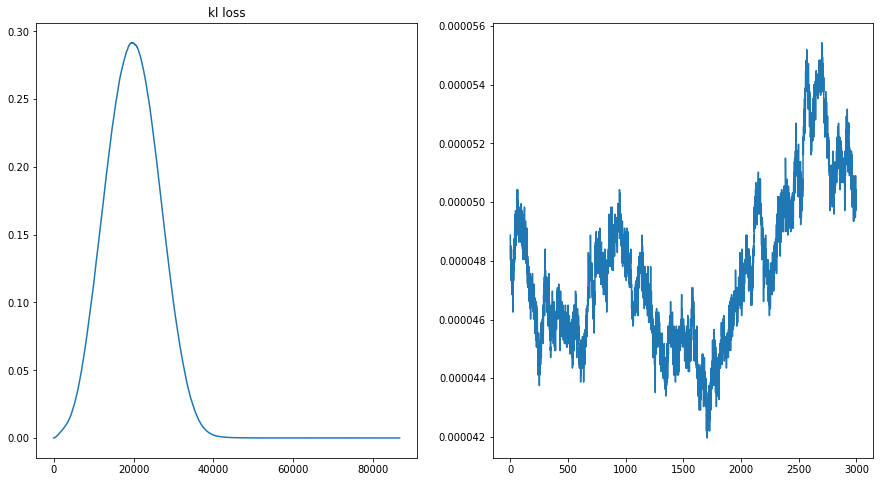

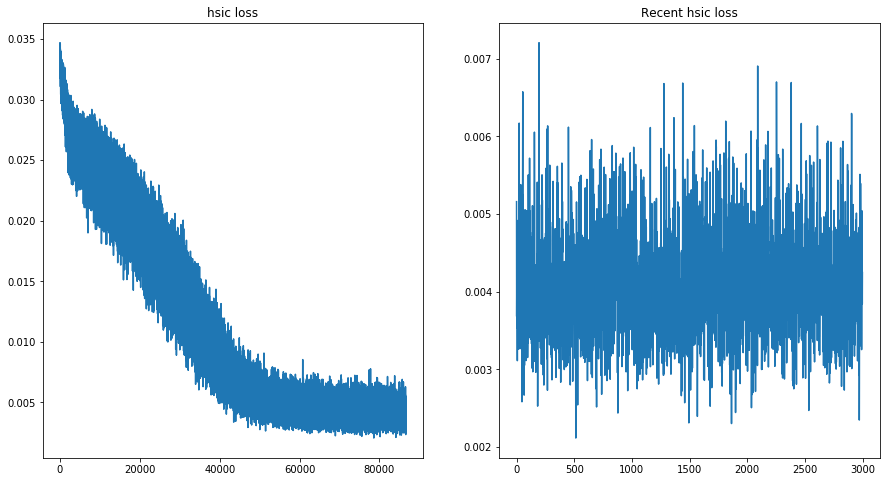

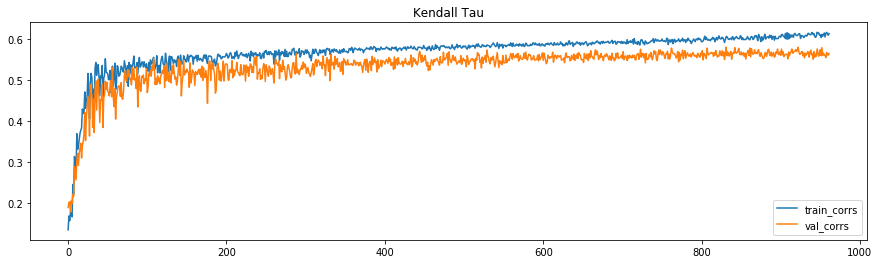

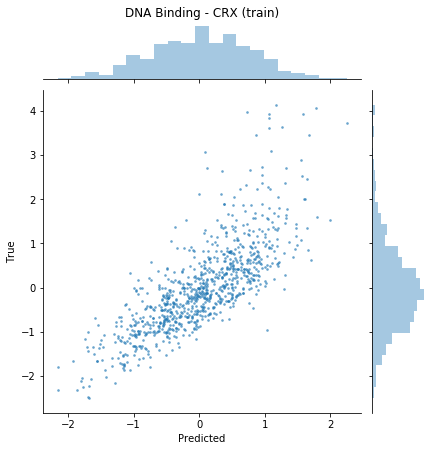

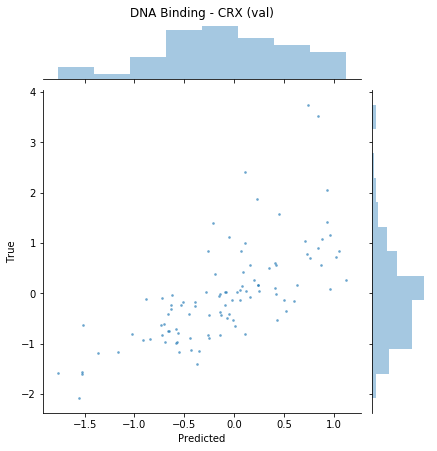

In [389]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_losses)
plt.title("log prob loss")

plt.subplot(122)
plt.plot(train_losses[-1000:])
plt.title("Recent log prob loss")

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_kl_losses)
plt.title("kl loss")

plt.subplot(122)
plt.plot(train_kl_losses[-3000:])

plt.figure(figsize=(15, 8))
plt.subplot(121)

plt.plot(train_hsic_losses)
plt.title("hsic loss")

plt.subplot(122)
plt.plot(train_hsic_losses[-3000:])

plt.title("Recent hsic loss")

plt.figure(figsize=(15, 4))

plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    preds = reparam.predict(train_X, model, qz, e)[:, :, 0].mean(1)
    jointplot(preds, train_labels, train_title)
    print('train_corrcoef:', np.corrcoef(preds, train_labels)[0, 1])

preds = reparam.predict(val_X, model, qz, e)[:, :, 0].mean(1)
jointplot(preds, val_labels, val_title)
print('val_corrcoef:', np.corrcoef(preds, val_labels)[0, 1])

In [123]:
X = torch.tensor(inputs, device=device)
Y = torch.tensor(labels, device=device)

In [431]:
import bb_opt.src.reparam_trainer as reparam

In [390]:
preds = reparam.predict(X, model, qz, e)[:, :, 0].mean(1)

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


val_corrcoef: 0.6463781079856966


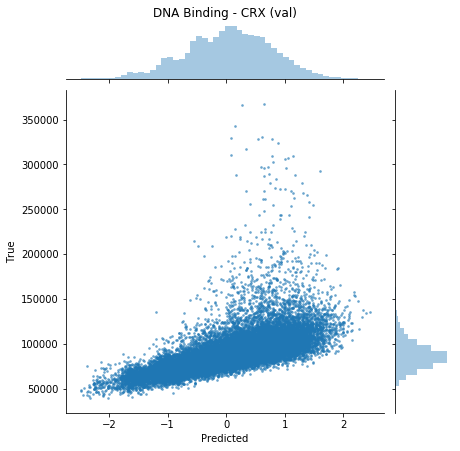

In [391]:
jointplot(preds, labels, val_title)
print('val_corrcoef:', np.corrcoef(preds, labels)[0, 1])

In [352]:
e = reparam.generate_prior_samples(100, e_dist, 'cpu')
preds = reparam.predict(X, model2, qz2, e, 'cpu')

In [353]:
preds.shape

torch.Size([32896, 100, 2])

In [354]:
max_pred_idx = preds[:, :, 0].argmax(dim=0)

In [355]:
pd.Series(max_pred_idx).value_counts()

13637    30
13783    15
13785    13
11358    10
13740     9
13636     5
12994     3
13784     2
30617     2
12993     2
13614     1
13601     1
23714     1
13761     1
30566     1
13638     1
13775     1
24149     1
13593     1
dtype: int64

In [356]:
max_pred_idx = [k.item() for k in max_pred_idx]

In [357]:
max_vals = [labels[k] for k in set(max_pred_idx)]

In [358]:
max_vals.sort()

In [359]:
max_vals = np.array(max_vals)

In [360]:
print(max_vals.max(), np.median(max_vals))

154481.3 134792.03


In [388]:
m = []
mean = []
for i in range(100):
    m += [np.max(np.random.choice(labels, sz[i]))]
    mean += [np.mean(np.random.choice(labels, sz[i]))]
m = np.array(m)
mean = np.array(mean)
print(np.median(m), np.median(mean))

133270.31 89019.63


In [363]:
model2 = model
qz2 = qz

In [381]:
m3 = m2
sz3 = sz

In [387]:
m2 = []
mean2 = []
sz = []
for i in range(100):
    e = reparam.generate_prior_samples(100, e_dist, 'cpu')
    preds = reparam.predict(X, model, qz, e, 'cpu')
    max_pred_idx = preds[:, :, 0].argmax(dim=0)
    max_pred_idx = [k.item() for k in max_pred_idx]
    max_vals = [labels[k] for k in set(max_pred_idx)]
    max_vals = np.array(max_vals)
    m2 += [np.max(max_vals)]
    mean2 += [np.mean(max_vals)]
    sz += [len(max_vals)]
m2 = np.array(m2)
sz = np.array(sz)
mean2 = np.array(mean2)
print(np.median(m2), np.median(sz), np.median(mean2))

174694.02 33.0 122786.95
